In [4]:
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
words = open('names.txt','r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [6]:
len(words)

32033

In [7]:
#Build the Vocabulary of characters and mappings to/from integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = { i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [8]:
#Build Dataset
from typing import List, Optional, Tuple

block_size = 3

def build_dataset(words:Optional[List]) -> Tuple:
    
    assert isinstance(words, list) , 'Give a valid input'
    
    X,Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 *len(words))
n2 = int(0.9 * len(words))  
Xtr, Ytr = build_dataset(words=words[:n1])
Xdev, Ydev = build_dataset(words=words[n1:n2])
Xte, Yte = build_dataset(words=words[n2:])

print(f"Train dataset Xtr {Xtr.shape}, Ytr {Ytr.shape}")
print(f"Val dataset Xdev {Xdev.shape}, Ydev {Ydev.shape}")
print(f"Test dataset Xte {Xte.shape}, Yte {Yte.shape}")   
    

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])
Train dataset Xtr torch.Size([182625, 3]), Ytr torch.Size([182625])
Val dataset Xdev torch.Size([22655, 3]), Ydev torch.Size([22655])
Test dataset Xte torch.Size([22866, 3]), Yte torch.Size([22866])


In [28]:
#MLP Revisited

n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator= g)
W1 = torch.randn((block_size * n_embd , n_hidden), generator= g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator= g) * 0.01
b2 = torch.randn(vocab_size , generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [29]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0],(batch_size,), generator= g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward pass
    emb = C[Xb] #embed the chartacters into vectors
    embcat = emb.view(emb.shape[0], -1) #now concatenate the vectors
    hpreact = embcat @ W1 +b1 #hidden layer preactivation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #Output layers
    loss = F.cross_entropy(logits, Yb)
    
    #backward pass
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    #update 
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    #track_stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.3221


In [51]:
h

tensor([[-1.0000,  0.9966, -1.0000,  ..., -0.9867,  0.6687,  0.9998],
        [-1.0000,  0.7579, -0.4107,  ...,  0.5295,  1.0000,  1.0000],
        [-0.9980, -0.8511, -0.9607,  ..., -1.0000,  1.0000,  0.9999],
        ...,
        [-0.9998, -0.8664, -1.0000,  ...,  0.9978, -1.0000, -0.9999],
        [-1.0000,  0.7579, -0.4107,  ...,  0.5295,  1.0000,  1.0000],
        [-1.0000, -0.9884, -1.0000,  ...,  0.9812,  0.9581,  1.0000]],
       grad_fn=<TanhBackward0>)

In [42]:
# We have more loss 27.8817 when we intantiated the weights and biases and the extreme values of logits will cause the loss to be very high

# 4 -dimensional example of the issue 
# `logits = torch.tensor([0.0,0.0,0.0,0.0])
# probs = torch.softmax(logits, dim = 0)
# loss = -probs[2].log()
# logits, probs, loss`

# `(tensor([0., 0., 0., 0.]),
#  tensor([0.2500, 0.2500, 0.2500, 0.2500]),
#  tensor(1.3863))`

#  the above example is when the logits are zero the prob is evely distributed

# the logit in the index 2 is changed and  we can notice the loss is less
# `logits = torch.tensor([0.0,0.0,5.0,0.0])
# probs = torch.softmax(logits, dim = 0)
# loss = -probs[2].log()
# logits, probs, loss`

# `(tensor([0., 0., 5., 0.]),
#  tensor([0.0066, 0.0066, 0.9802, 0.0066]),
#  tensor(0.0200))`

#  Now when the logits of other is index is given extreme values the loss is very high
# `logits = torch.tensor([10.0,0.0,5.0,0.0])
# probs = torch.softmax(logits, dim = 0)
# loss = -probs[2].log()
# logits, probs, loss`

# `(tensor([10.,  0.,  5.,  0.]),
#  tensor([9.9322e-01, 4.5092e-05, 6.6922e-03, 4.5092e-05]),
#  tensor(5.0068))`

In [43]:
#We can achieve less loss during the first iteration
#By making the weights and biases close to zero 
#we cannot make the weight to zero because they can permenantly damage the neurons in the network during back propagation

In [14]:
## the logits ranges from -1 to 1 because of tanh activation function
#it basically squashes the valuews between -1 to 1
#output of 
# h
# tensor([[-1.0000,  0.9966, -1.0000,  ..., -0.9867,  0.6687,  0.9998],
#         [-1.0000,  0.7579, -0.4107,  ...,  0.5295,  1.0000,  1.0000],
#         [-0.9980, -0.8511, -0.9607,  ..., -1.0000,  1.0000,  0.9999],
#         ...,
#         [-0.9998, -0.8664, -1.0000,  ...,  0.9978, -1.0000, -0.9999],
#         [-1.0000,  0.7579, -0.4107,  ...,  0.5295,  1.0000,  1.0000],
#         [-1.0000, -0.9884, -1.0000,  ...,  0.9812,  0.9581,  1.0000]],
#        grad_fn=<TanhBackward0>)

#from the below histogram we see that there are extreme values of -1 and 1 which arew not good for back propagation where
#these values will make the gradient 0 and potentially will make the neurons dead which in turn wont be useful for the other iterations
#because the neurons weights wont be updated

In [32]:
##if the entire colum  is white then it becomes dead neuron and they never learn
#white is the area where the logits are extreme values like -1 , -0.99 and 1 and 0.99

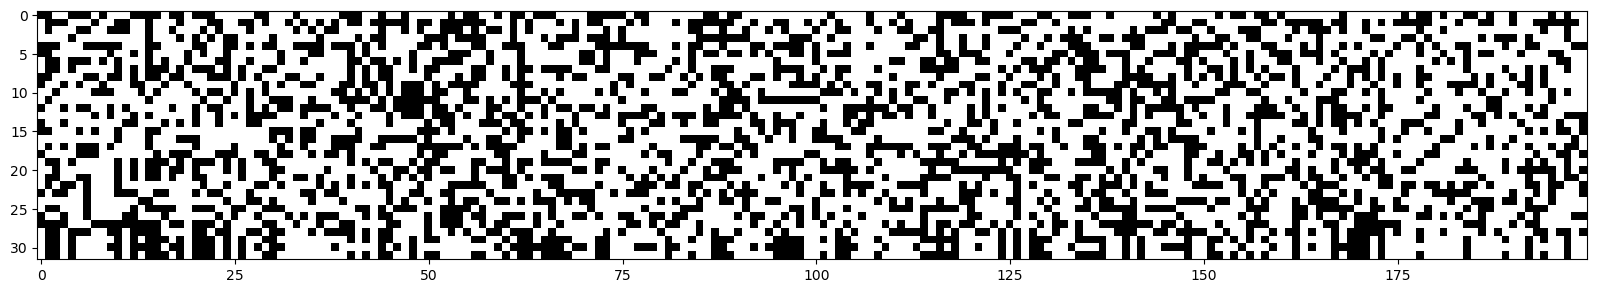

In [31]:
plt.figure(figsize= (20,10))
plt.imshow(h.abs() >  0.99, cmap = 'gray', interpolation = 'nearest')
#the h is the output when ran for the first iteration

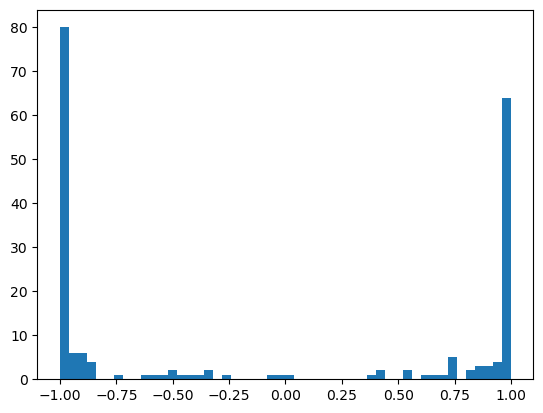

In [26]:
plt.hist(h.view(-1).tolist(), 50);

(array([80.,  6.,  6.,  4.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  2.,
         1.,  1.,  1.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  2.,
         0.,  1.,  1.,  1.,  5.,  0.,  2.,  3.,  3.,  4., 64.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

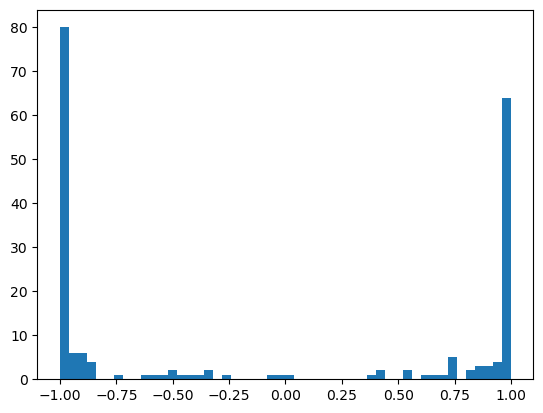

In [27]:
plt.hist(h.view(-1).tolist(), 50)

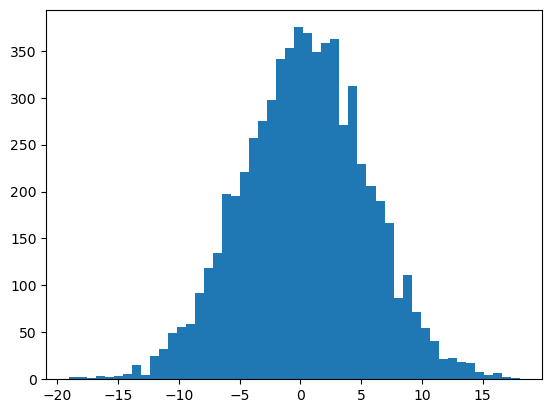

In [34]:
plt.hist(hpreact.view(-1).tolist(),50);

In [33]:
## relu , sigmoid, tanh will be affected from thjis issue
# Leaky Relu and ELU wont be affected much from this issue

In [40]:
# 4 -dimensional example of the issue 
logits = torch.tensor([10.0,0.0,5.0,0.0])
probs = torch.softmax(logits, dim = 0)
loss = -probs[2].log()
logits, probs, loss

(tensor([10.,  0.,  5.,  0.]),
 tensor([9.9322e-01, 4.5092e-05, 6.6922e-03, 4.5092e-05]),
 tensor(5.0068))

In [27]:
emb.shape, emb.view(32, -1).shape, emb.view(-1, 30).shape

(torch.Size([32, 3, 10]), torch.Size([32, 30]), torch.Size([32, 30]))

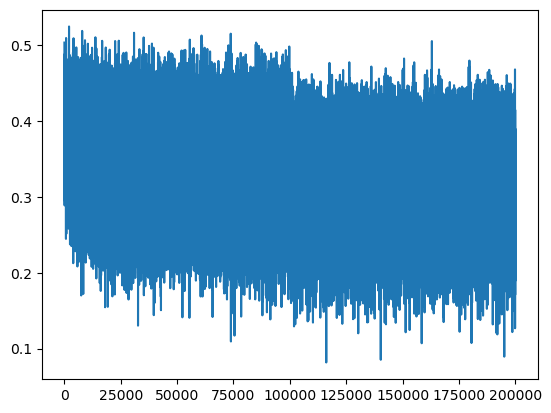

In [15]:
plt.plot(lossi)

In [16]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train' : (Xtr,Ytr),
        'val' : (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    emb = C[x]
    embcat = emb.view(x.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits =  h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')   

train 2.06957745552063
val 2.131200075149536


In [17]:
#sample the model
g = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
    out = []
    context = [0] * block_size
    
    while True:
        
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs =  F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs,
                               num_samples=1,
                               generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out))
        

mora.
mayah.
seel.
ndyn.
alerethruthadrie.
cadelyn.
elin.
shi.
jen.
eden.
est.
aarvelyzion.
kamin.
shub.
roshimies.
kin.
renlynn.
novana.
ubeen.
der.


## Version 2 to tackle the above issue

In [43]:
#MLP Revisited

n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator= g) 
W1 = torch.randn((block_size * n_embd , n_hidden), generator= g) * 0.2 
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator= g) * 0.01
b2 = torch.randn(vocab_size , generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [44]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0],(batch_size,), generator= g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward pass
    emb = C[Xb] #embed the chartacters into vectors
    embcat = emb.view(emb.shape[0], -1) #now concatenate the vectors
    hpreact = embcat @ W1 +b1 #hidden layer preactivation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #Output layers
    loss = F.cross_entropy(logits, Yb)
    
    #backward pass
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    #update 
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    #track_stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.3135


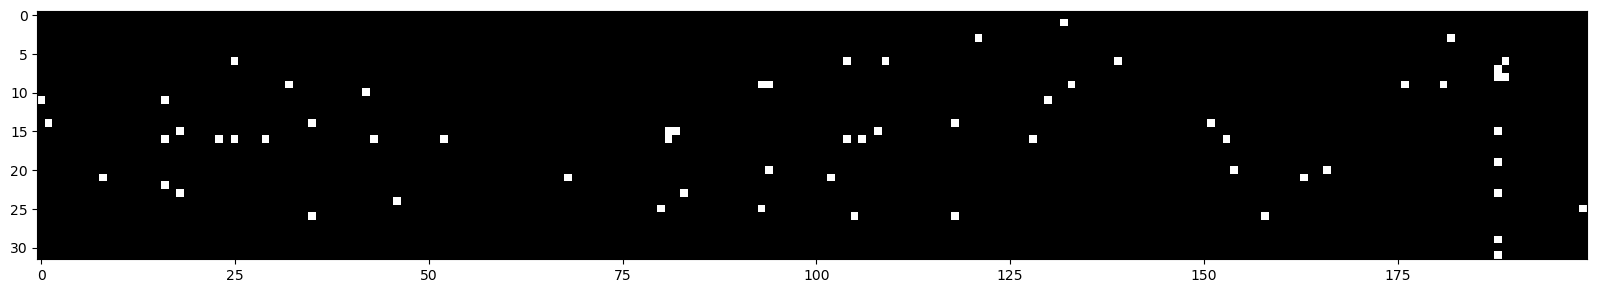

In [45]:
plt.figure(figsize= (20,10))
plt.imshow(h.abs() >  0.99, cmap = 'gray', interpolation = 'nearest')
#the h is the output when ran for the first iteration

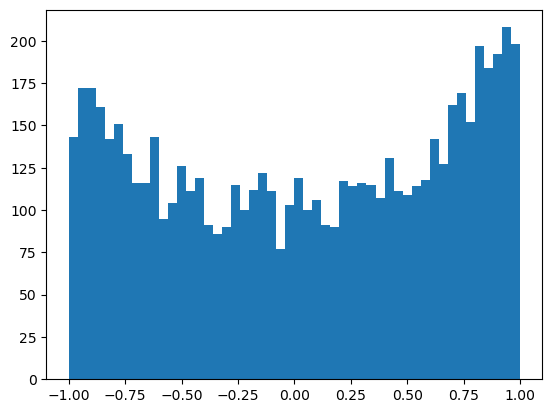

In [46]:
plt.hist(h.view(-1).tolist(), 50);

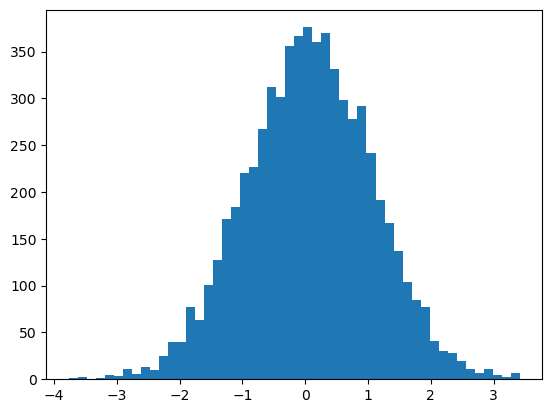

In [47]:
plt.hist(hpreact.view(-1).tolist(),50);

## Run with full sample

In [48]:
#MLP Revisited

n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator= g) 
W1 = torch.randn((block_size * n_embd , n_hidden), generator= g) * 0.2 
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator= g) * 0.01
b2 = torch.randn(vocab_size , generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [49]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0],(batch_size,), generator= g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward pass
    emb = C[Xb] #embed the chartacters into vectors
    embcat = emb.view(emb.shape[0], -1) #now concatenate the vectors
    hpreact = embcat @ W1 +b1 #hidden layer preactivation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #Output layers
    loss = F.cross_entropy(logits, Yb)
    
    #backward pass
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    #update 
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    #track_stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
#     break

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


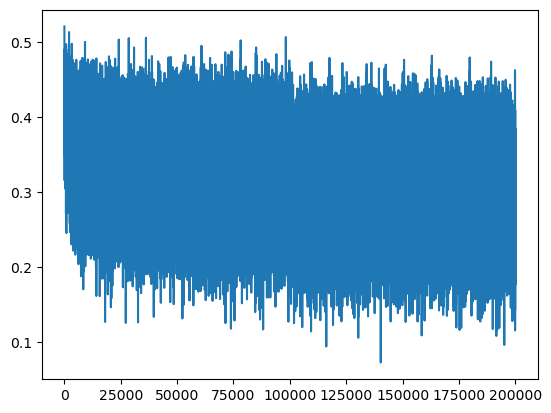

In [50]:
plt.plot(lossi)

In [51]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train' : (Xtr,Ytr),
        'val' : (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    emb = C[x]
    embcat = emb.view(x.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits =  h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')   

train 2.0355966091156006
val 2.102678060531616


In [52]:
#sample the model
g = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
    out = []
    context = [0] * block_size
    
    while True:
        
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs =  F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs,
                               num_samples=1,
                               generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out))
        

mora.
mayah.
see.
mad.
ryll.
renvestendraegusteredielin.
shi.
jen.
edeiseananar.
kayzion.
kamin.
shubergianaiya.
kinde.
jennex.
teron.
ububynder.
yarue.
els.
kayshaykella.
hal.


In [53]:
# W1 = torch.randn((block_size * n_embd , n_hidden), generator= g) * 0.2 
# b1 = torch.randn(n_hidden, generator=g) * 0.01
# W2 = torch.randn((n_hidden, vocab_size), generator= g) * 0.01
# b2 = torch.randn(vocab_size , generator=g) * 0

#How to choose the numbers that we multiply with the weights and biases

#Notice that the standard deviation is more after the matrix multiplication for th gaussian inputs
#it is wise that the standard deviation should be the same even after the matrix ,multiplication


x_mean 0.0057, x_std 1.0001
Y_mean 0.0044, y_std 3.1951


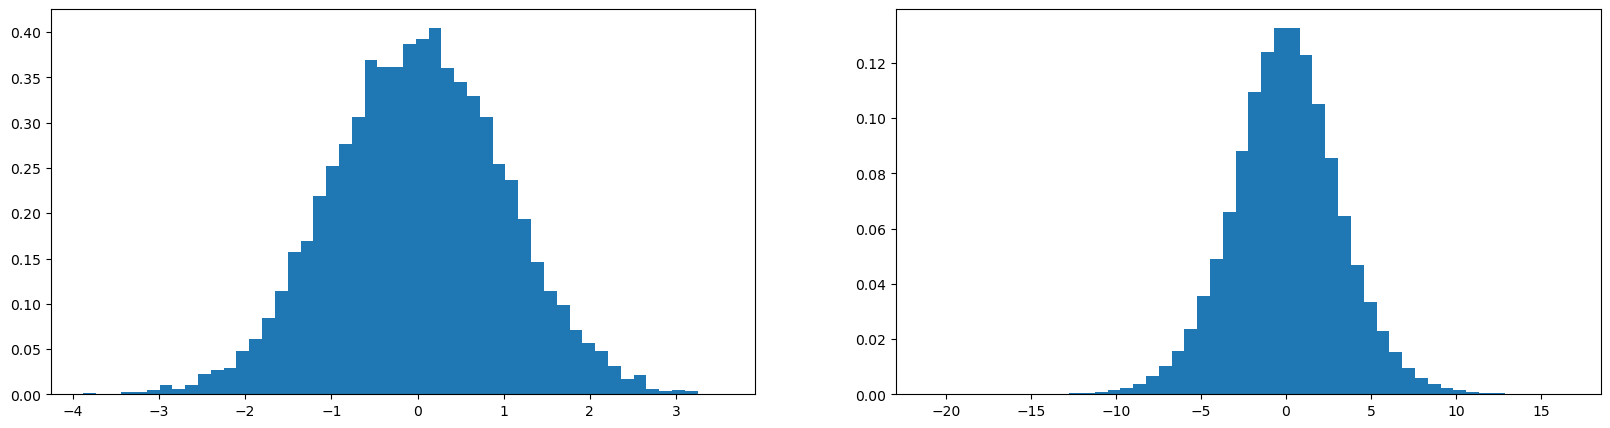

In [60]:
x = torch.randn(1000, 10)
w = torch.randn(10,200)
y = x @ w
print(f"x_mean {x.mean():.4f}, x_std {x.std():.4f}")
print(f'Y_mean {y.mean():.4f}, y_std {y.std():.4f}')
plt.figure(figsize = (20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True);

In [ ]:
# after multiplying the weights by 5 the standar deviation has been increased a lot for the output(matrix multiplication)

x_mean 0.0024, x_std 0.9927
Y_mean -0.0308, y_std 15.7457


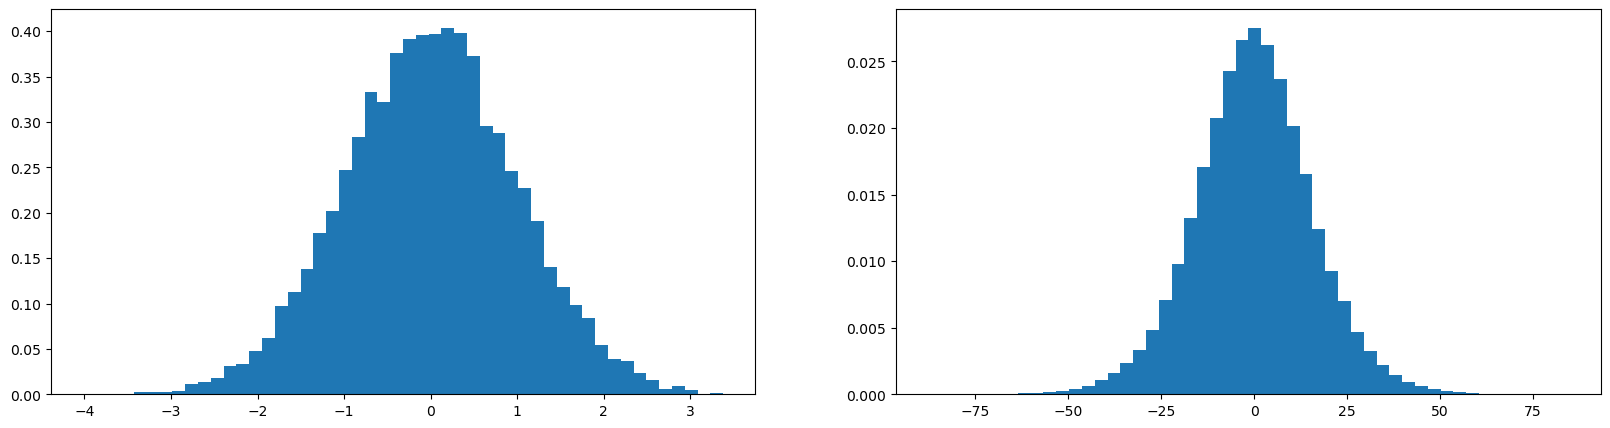

In [61]:
x = torch.randn(1000, 10)
w = torch.randn(10,200) * 5
y = x @ w
print(f"x_mean {x.mean():.4f}, x_std {x.std():.4f}")
print(f'Y_mean {y.mean():.4f}, y_std {y.std():.4f}')
plt.figure(figsize = (20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True);

x_mean 0.0176, x_std 1.0045
Y_mean 0.0000, y_std 1.1062


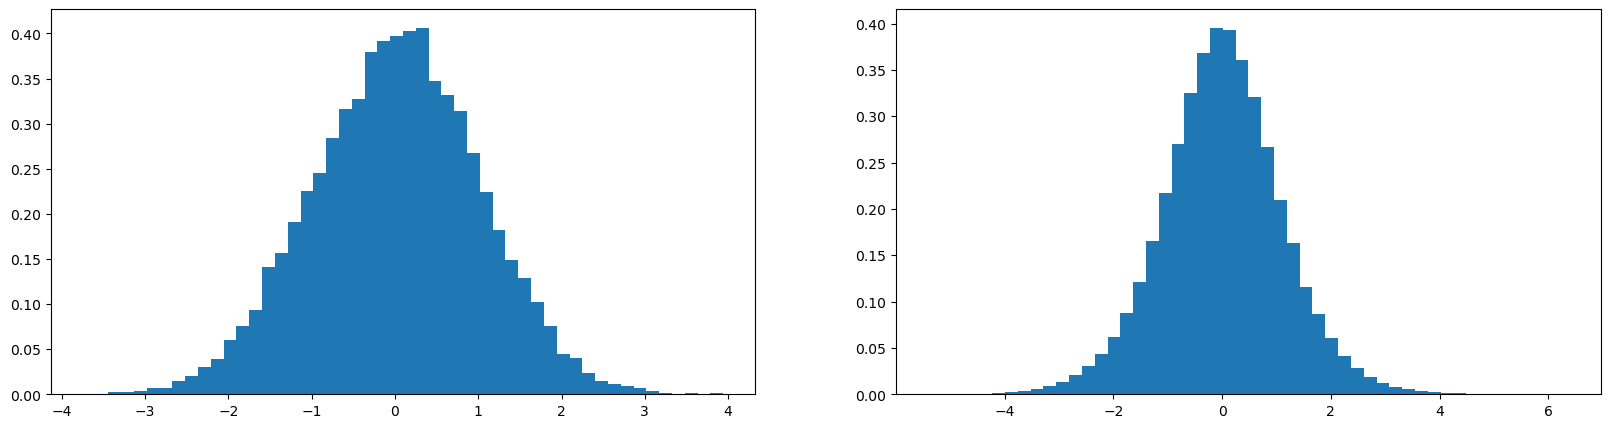

In [70]:
x = torch.randn(1000, 10)
w = torch.randn(10,200) * 0.34
y = x @ w
print(f"x_mean {x.mean():.4f}, x_std {x.std():.4f}")
print(f'Y_mean {y.mean():.4f}, y_std {y.std():.4f}')
plt.figure(figsize = (20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True);

In [ ]:
#Now the standard deviation is almost same for both the input adn the output

#the common formula to find the number thatr need to be multiplied is to divide by square root of the fan n of the input


x_mean -0.0012, x_std 1.0071
Y_mean 0.0006, y_std 0.9977


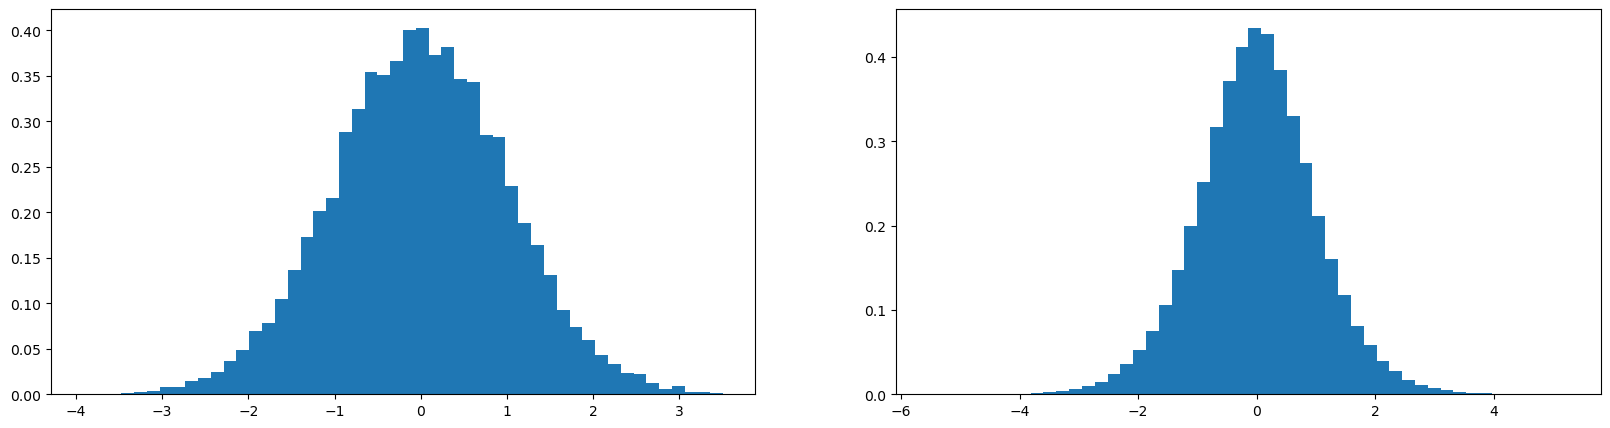

In [71]:
x = torch.randn(1000, 10)
w = torch.randn(10,200) / 10**0.5
y = x @ w
print(f"x_mean {x.mean():.4f}, x_std {x.std():.4f}")
print(f'Y_mean {y.mean():.4f}, y_std {y.std():.4f}')
plt.figure(figsize = (20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True);

In [73]:
#We do have kaiming init to get the absolute value(known as Gain) to initialize the weights and biases according to the activations

In [74]:
#for tanh we can calulate the constant number be 
(5/3) / ((block_size * n_embd)**0.5)

0.3042903097250923

In [75]:
#updating the initializing the weights
#but in the modern eep learning frame work this method is optomized and need not to worry about initializing the weights

# n_embd = 10
# n_hidden = 200

# g = torch.Generator().manual_seed(2147483647)
# C = torch.randn((vocab_size, n_embd), generator= g) 
# W1 = torch.randn((block_size * n_embd , n_hidden), generator= g) * (5/3) / ((block_size * n_embd)**0.5)
# b1 = torch.randn(n_hidden, generator=g) * 0.01
# W2 = torch.randn((n_hidden, vocab_size), generator= g) * 0.01
# b2 = torch.randn(vocab_size , generator=g) * 0

# parameters = [C, W1, b1, W2, b2]
# print(sum(p.nelement() for p in parameters))
# for p in parameters:
#     p.requires_grad = True

# Batch Normalization

In [104]:
#MLP Revisited

n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator= g) 
W1 = torch.randn((block_size * n_embd , n_hidden), generator= g) * (5/3) / ((block_size * n_embd)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator= g) * 0.01
b2 = torch.randn(vocab_size , generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [105]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0],(batch_size,), generator= g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward pass
    emb = C[Xb] #embed the chartacters into vectors
    embcat = emb.view(emb.shape[0], -1) #now concatenate the vectors
    hpreact = embcat @ W1 +b1 #hidden layer preactivation
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim = True) / hpreact.std(0, keepdims= True)) + bnbias #we only want the logits to be roughly gaussian and only during initializing
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #Output layers
    loss = F.cross_entropy(logits, Yb)
    
    #backward pass
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    #update 
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    #track_stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
#     break

      0/ 200000: 3.3153
  10000/ 200000: 2.1706
  20000/ 200000: 2.3339
  30000/ 200000: 2.5143
  40000/ 200000: 1.9491
  50000/ 200000: 2.3896
  60000/ 200000: 2.3723
  70000/ 200000: 2.0383
  80000/ 200000: 2.3944
  90000/ 200000: 2.1295
 100000/ 200000: 1.8097
 110000/ 200000: 2.2099
 120000/ 200000: 1.9458
 130000/ 200000: 2.3309
 140000/ 200000: 2.2505
 150000/ 200000: 2.2001
 160000/ 200000: 1.8520
 170000/ 200000: 1.7781
 180000/ 200000: 1.9428
 190000/ 200000: 1.8188


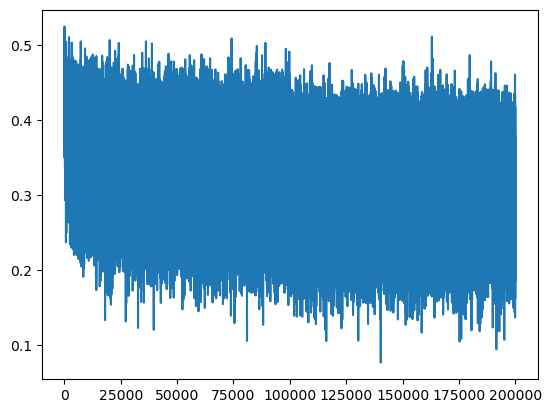

In [110]:
plt.plot(lossi)

In [111]:
# Calculate the batch normalization at the end of the training

with torch.no_grad():
    
    #pass the training  set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    
    #measure the mean and std across the entire trainiong set
    bnmean = hpreact.mean(0, keepdims = True)
    bnstd =  hpreact.std(0, keepdim = True)

In [114]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train' : (Xtr,Ytr),
        'val' : (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    emb = C[x]
    embcat = emb.view(x.shape[0], -1)
    hpreact = embcat @ W1 +b1 #hidden layer preactivation
#     hpreact = bngain * (hpreact - hpreact.mean(0, keepdim = True) / hpreact.std(0, keepdims= True)) + bnbias #we only want the logits to be roughly gaussian and only during initializing
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)
    logits =  h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')   

train 2.5238726139068604
val 2.542955160140991


In [99]:
hpreact.shape

torch.Size([32, 200])

In [100]:
hpreact.mean(0, keepdim = True).shape, hpreact.mean(1, keepdims= True).shape

(torch.Size([1, 200]), torch.Size([32, 1]))

In [101]:
hpreact.std(0, keepdim = True).shape

torch.Size([1, 200])

In [115]:
#we only want the logits to be roughly gaussian and only during initializing
#we dont want to force it to be gaussian all the time 
#We want the neurons to move around like streched or squeezed, more trigger happy, less trigger happy and we allow  -
# - back propagation to tell us how the distribution to move around
# we will additionally scale the gain, gonna add batch_normalization_gain bngain and bnbias

# Batch Normalization 2.0

In [117]:
#MLP Revisited

n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator= g) 
W1 = torch.randn((block_size * n_embd , n_hidden), generator= g) * (5/3) / ((block_size * n_embd)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator= g) * 0.01
b2 = torch.randn(vocab_size , generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [118]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0],(batch_size,), generator= g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward pass
    emb = C[Xb] #embed the chartacters into vectors
    embcat = emb.view(emb.shape[0], -1) #now concatenate the vectors
    #Linear Layer
    hpreact = embcat @ W1 +b1 #hidden layer preactivation
    #Batch Norm Layer 
    
    bnmeani = hpreact.mean(0, keepdim = True)
    bnstdi = hpreact.std(0, keepdim = True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
        
    #Non Linearity
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #Output layers
    loss = F.cross_entropy(logits, Yb)
    
    #backward pass
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    #update 
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    #track_stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
#     break

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


In [119]:
## When the Neural Networks are batch normalized the baises we add to the linear layer will not be useful 
# hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
# because we subtract the logits with bnmeani and adding bnbias so it is fine to set the bias as zero because-
#  - any difference

In [173]:
words = open('names.txt','r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [174]:
#Build the Vocabulary of characters and mappings to/from integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = { i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [172]:
words[:8]

['yuheng',
 'diondre',
 'xavien',
 'jori',
 'juanluis',
 'erandi',
 'phia',
 'samatha']

In [ ]:
#Build Dataset
from typing import List, Optional, Tuple

block_size = 3

def build_dataset(words:Optional[List]) -> Tuple:
    
    assert isinstance(words, list) , 'Give a valid input'
    
    X,Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 *len(words))
n2 = int(0.9 * len(words))  
Xtr, Ytr = build_dataset(words=words[:n1])
Xdev, Ydev = build_dataset(words=words[n1:n2])
Xte, Yte = build_dataset(words=words[n2:])

print(f"Train dataset Xtr {Xtr.shape}, Ytr {Ytr.shape}")
print(f"Val dataset Xdev {Xdev.shape}, Ydev {Ydev.shape}")
print(f"Test dataset Xte {Xte.shape}, Yte {Yte.shape}")   
    

# PyTorchify the code

In [190]:
#Lets train a deeper Network

class Linear:
    
    def __init__(self,
                fan_in: int,
                fan_out: int,
                bias: bool = True):
        
        self.weight = torch.randn((fan_in, fan_out), generator = g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, 
                 x: torch.Tensor):
        
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else []) # this will concatenate the list
    

class BatchNorm1d:
    
    def __init__(self,
                dim : int| tuple,
                eps: float = 1e-5,
                momentum = 0.1):
        
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        #parameters (trained withg back propagation)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        #buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    
    def __call__(self, x: torch.tensor):
        
        #calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdims = True) # batch mean
            xvar = x.var(0, keepdims = True, unbiased = True) # batch variance
        
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps)  # normalise to unit variance , sqrt of variance is std
        self.out = self.gamma * xhat + self.beta
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum *xmean
                self.running_var = (1- self.momentum) * self.running_var + self.momentum *xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []


n_embd = 10 #the dimensionality of the character embedding layer
n_hidden = 100 # the number of neurons in the hidden layer of teh MLP
g = torch.Generator().manual_seed(2147483647) #for reproducibility

C = torch.randn((vocab_size, n_embd), generator = g)
layers = [
    Linear(n_embd * block_size , n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    #last layer : make less confident
    layers[-1].weight *= 0.1
    #all other layers: apply again
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
            
#parameters for back propagation

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True
    


46497


In [184]:
#same optimization as the last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []   #update to data ratio that is udpate to the gradient to the data ratio

for i in range(max_steps):
    
    #minibatch construct 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]  #batch X,Y
    
    #forward pass
    emb = C[Xb] #embed the characters into vectors
    x = emb.view(emb.shape[0], -1) #concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) #loss function
    
    #backward pass
    for layer in layers:
        layer.out.retain_grad()  #after Debug: would take out retian_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01  #step learning rate decay
    for p in parameters:
        p.data += -lr *p.grad
        
    #tarck stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr *p.grad).std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break
    
    
    

      0/ 200000: 3.296155


layer 1 (      Tanh): mean -0.04, std  1, saturated: 21.97%
layer 3 (      Tanh): mean -0.01, std  1, saturated: 11.00%
layer 5 (      Tanh): mean +0.01, std  1, saturated: 13.00%
layer 7 (      Tanh): mean -0.05, std  1, saturated: 13.34%
layer 9 (      Tanh): mean +0.00, std  1, saturated: 10.53%


Text(0.5, 1.0, 'activation distribution')

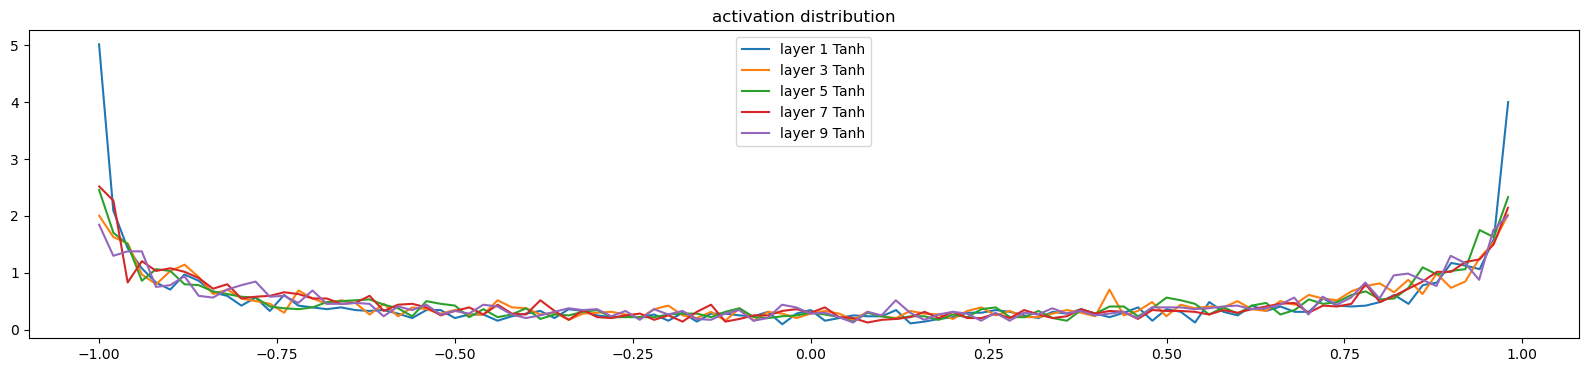

In [185]:
#Visualize the histograms
plt.figure(figsize = (20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %2.f, saturated: %.2f%%' %(i,
                                                                           layer.__class__.__name__,
                                                                           t.mean(),
                                                                           t.std(),
                                                                           (t.abs()> 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density = True)
#         print(hx)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} {layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000024, std 3.353993e-03
layer 3 (      Tanh): mean +0.000012, std 3.157345e-03
layer 5 (      Tanh): mean -0.000004, std 2.925864e-03
layer 7 (      Tanh): mean +0.000036, std 2.715701e-03
layer 9 (      Tanh): mean +0.000020, std 2.308167e-03


Text(0.5, 1.0, 'gradient distribution')

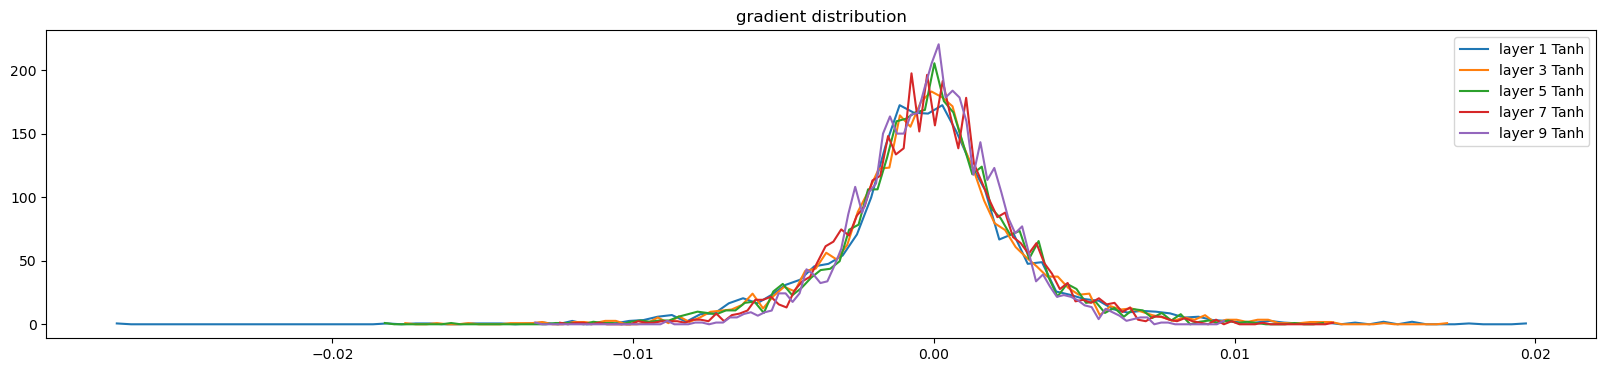

In [168]:
#Visualize the histograms
plt.figure(figsize = (20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' %(i,
                                                                           layer.__class__.__name__,
                                                                           t.mean(),
                                                                           t.std(),
                                                                           ))
        hy, hx = torch.histogram(t, density = True)
#         print(hx)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} {layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) } mean +0.000980 | std 1.189170e-02 | gard:data ratio 1.189149e-02
weight  (30, 100) } mean +0.000118 | std 1.005291e-02 | gard:data ratio 3.214557e-02
weight (100, 100) } mean +0.000033 | std 7.821214e-03 | gard:data ratio 4.653364e-02
weight (100, 100) } mean -0.000107 | std 6.655623e-03 | gard:data ratio 3.925852e-02
weight (100, 100) } mean -0.000017 | std 6.086042e-03 | gard:data ratio 3.605768e-02
weight (100, 100) } mean -0.000077 | std 5.075620e-03 | gard:data ratio 3.015269e-02
weight  (100, 27) } mean +0.000000 | std 2.056585e-02 | gard:data ratio 2.909911e-01


Text(0.5, 1.0, 'weights gradient distribution')

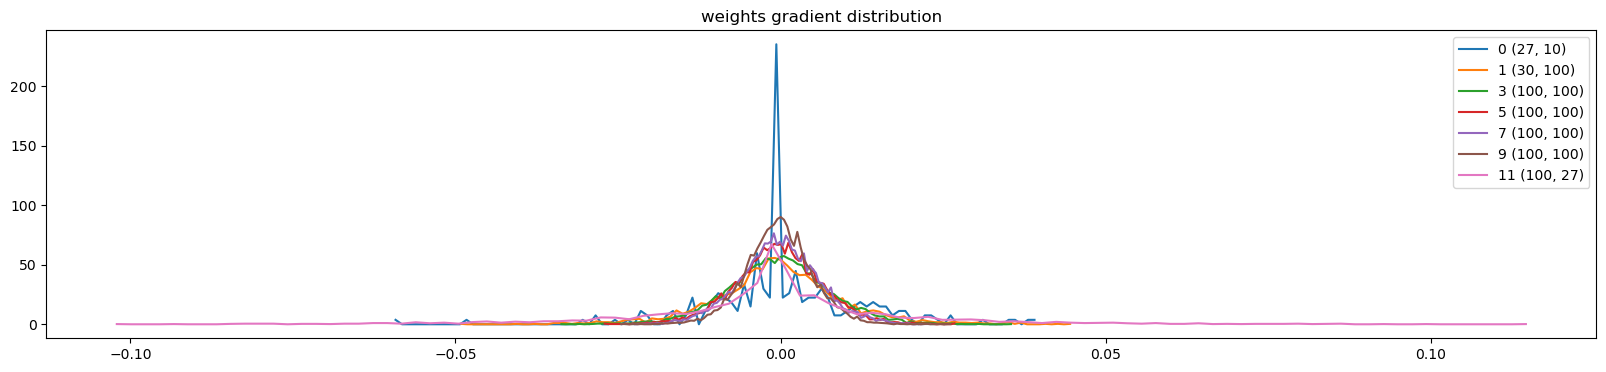

In [169]:
#weights gardient distribution

plt.figure(figsize = (20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
#     print(p.grad)
    if p.ndim == 2:
        print('weight %10s } mean %+f | std %e | gard:data ratio %e' %(tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy , hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title('weights gradient distribution')

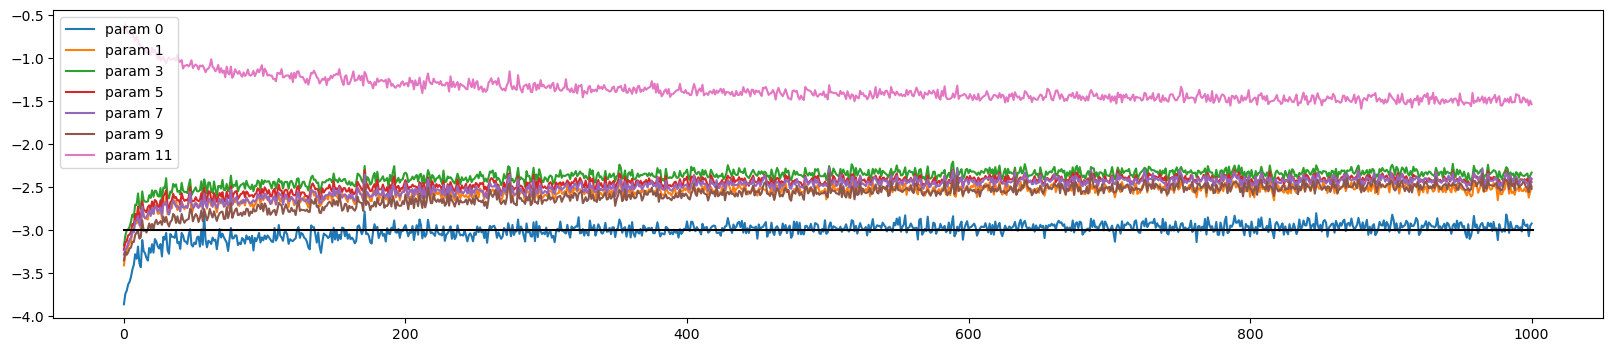

In [170]:
#gardient updates  to data  ratio visualisation

plt.figure(figsize=(20,4))
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' %i)
    
plt.plot([0, len(ud)], [-3,-3], 'k')  #these ratios should be  ~1e-3 , indicate on plot
plt.legend(legends);

In [180]:
ud[:2]

[[-3.865157127380371,
  -3.412102699279785,
  0.0,
  -3.1803252696990967,
  0.0,
  -3.229656934738159,
  0.0,
  -3.287508249282837,
  0.0,
  -3.355048656463623,
  0.0,
  -0.6329792141914368,
  0.0],
 [-3.7435696125030518,
  -3.2904248237609863,
  -0.11222029477357864,
  -3.0660524368286133,
  -0.10072939842939377,
  -3.147493362426758,
  -0.1441110074520111,
  -3.222956418991089,
  -0.13560500741004944,
  -3.2517669200897217,
  -0.11484075337648392,
  -0.6054425239562988,
  -0.179245725274086]]

# Add Batch Normalization

In [193]:
#Lets train a deeper Network

class Linear:
    
    def __init__(self,
                fan_in: int,
                fan_out: int,
                bias: bool = True):
        
        self.weight = torch.randn((fan_in, fan_out), generator = g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, 
                 x: torch.Tensor):
        
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else []) # this will concatenate the list
    

class BatchNorm1d:
    
    def __init__(self,
                dim : int| tuple,
                eps: float = 1e-5,
                momentum = 0.1):
        
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        #parameters (trained withg back propagation)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        #buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    
    def __call__(self, x: torch.tensor):
        
        #calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdims = True) # batch mean
            xvar = x.var(0, keepdims = True, unbiased = True) # batch variance
        
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps)  # normalise to unit variance , sqrt of variance is std
        self.out = self.gamma * xhat + self.beta
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum *xmean
                self.running_var = (1- self.momentum) * self.running_var + self.momentum *xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []


n_embd = 10 #the dimensionality of the character embedding layer
n_hidden = 100 # the number of neurons in the hidden layer of teh MLP
g = torch.Generator().manual_seed(2147483647) #for reproducibility

C = torch.randn((vocab_size, n_embd), generator = g)
layers = [
    Linear(n_embd * block_size , n_hidden), BatchNorm1d(n_hidden) ,Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden) ,Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden) ,Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden) ,Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden) ,Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size) 
]

with torch.no_grad():
    #last layer : make less confident
#     layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    #all other layers: apply again
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
            
#parameters for back propagation

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True
    


47551


In [194]:
#same optimization as the last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []   #update to data ratio that is udpate to the gradient to the data ratio

for i in range(max_steps):
    
    #minibatch construct 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]  #batch X,Y
    
    #forward pass
    emb = C[Xb] #embed the characters into vectors
    x = emb.view(emb.shape[0], -1) #concatenate the vectors
    for layer in layers:
        x = layer(x)
#     print(x.shape, Yb.shape)
    loss = F.cross_entropy(x, Yb) #loss function
    
    #backward pass
    for layer in layers:
        layer.out.retain_grad()  #after Debug: would take out retian_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01  #step learning rate decay
    for p in parameters:
        p.data += -lr *p.grad
        
    #tarck stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr *p.grad).std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break
    
    
    

      0/ 200000: 3.287031


layer 2 (      Tanh): mean -0.00, std  1, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std  1, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std  1, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std  1, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std  1, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

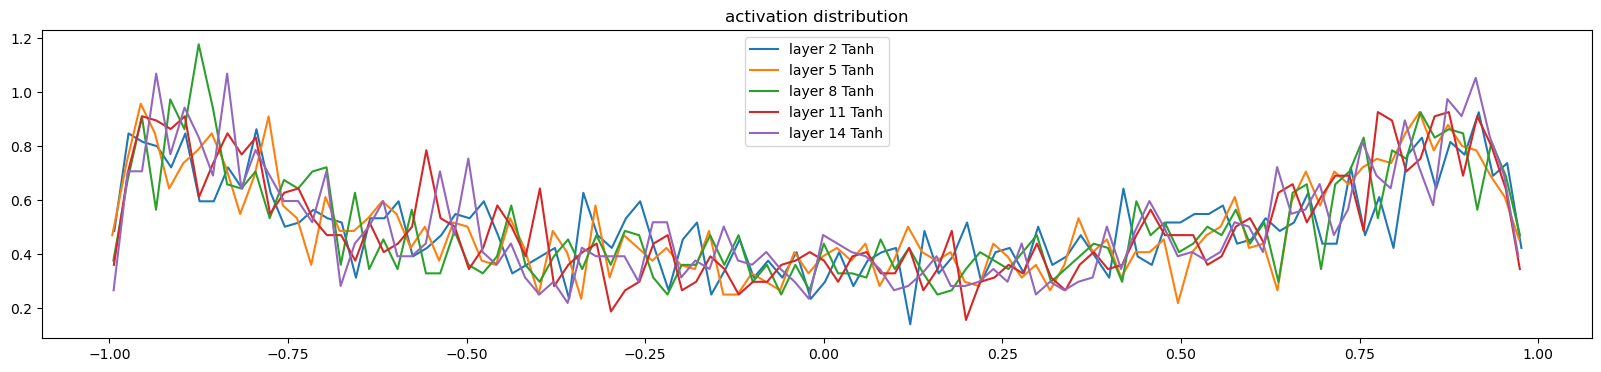

In [195]:
#Visualize the histograms
plt.figure(figsize = (20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %2.f, saturated: %.2f%%' %(i,
                                                                           layer.__class__.__name__,
                                                                           t.mean(),
                                                                           t.std(),
                                                                           (t.abs()> 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density = True)
#         print(hx)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} {layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.682957e-03
layer 5 (      Tanh): mean -0.000000, std 3.262611e-03
layer 8 (      Tanh): mean -0.000000, std 2.973732e-03
layer 11 (      Tanh): mean +0.000000, std 2.741112e-03
layer 14 (      Tanh): mean +0.000000, std 2.584294e-03


Text(0.5, 1.0, 'gradient distribution')

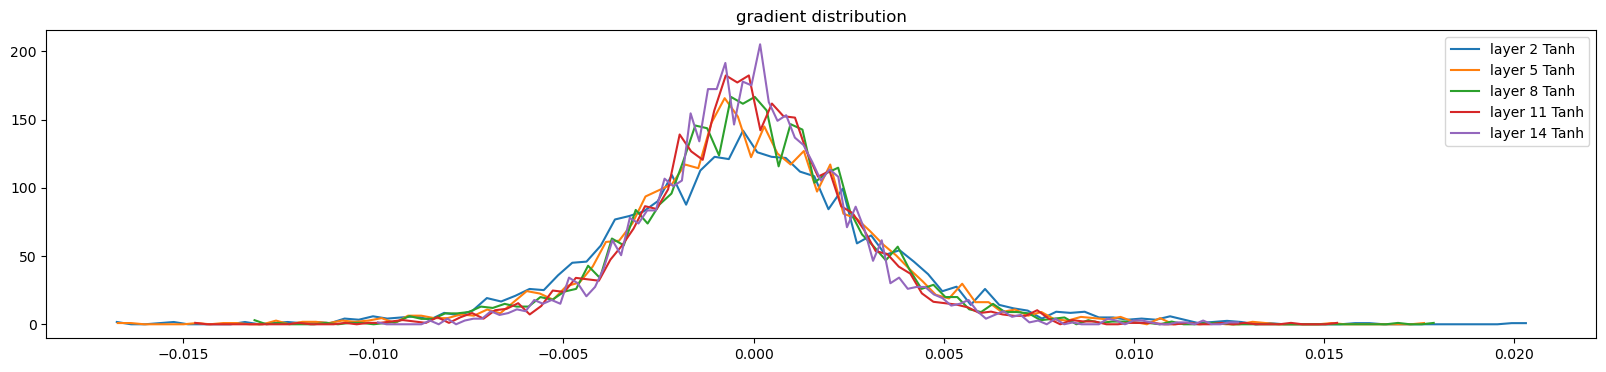

In [196]:
#Visualize the histograms
plt.figure(figsize = (20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' %(i,
                                                                           layer.__class__.__name__,
                                                                           t.mean(),
                                                                           t.std(),
                                                                           ))
        hy, hx = torch.histogram(t, density = True)
#         print(hx)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} {layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) } mean -0.000000 | std 1.019888e-02 | gard:data ratio 1.018849e-02
weight  (30, 100) } mean +0.000092 | std 8.238437e-03 | gard:data ratio 2.635841e-02
weight (100, 100) } mean +0.000031 | std 7.318118e-03 | gard:data ratio 4.377148e-02
weight (100, 100) } mean -0.000019 | std 6.662027e-03 | gard:data ratio 3.949898e-02
weight (100, 100) } mean -0.000019 | std 5.821519e-03 | gard:data ratio 3.468163e-02
weight (100, 100) } mean +0.000053 | std 5.445300e-03 | gard:data ratio 3.243370e-02
weight  (100, 27) } mean -0.000165 | std 1.046846e-02 | gard:data ratio 6.281270e-02


Text(0.5, 1.0, 'weights gradient distribution')

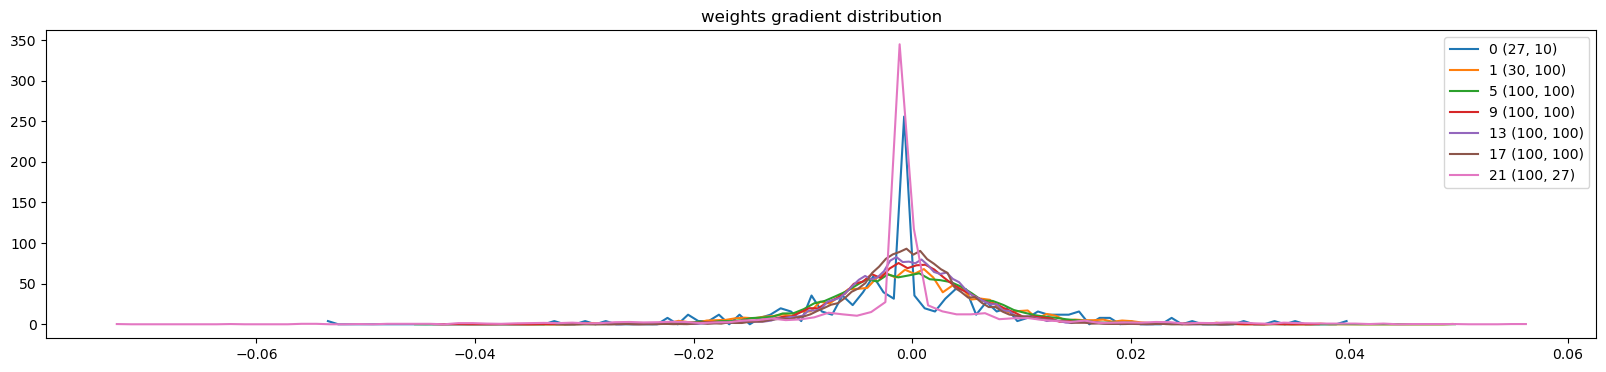

In [197]:
#weights gardient distribution

plt.figure(figsize = (20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
#     print(p.grad)
    if p.ndim == 2:
        print('weight %10s } mean %+f | std %e | gard:data ratio %e' %(tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy , hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title('weights gradient distribution')

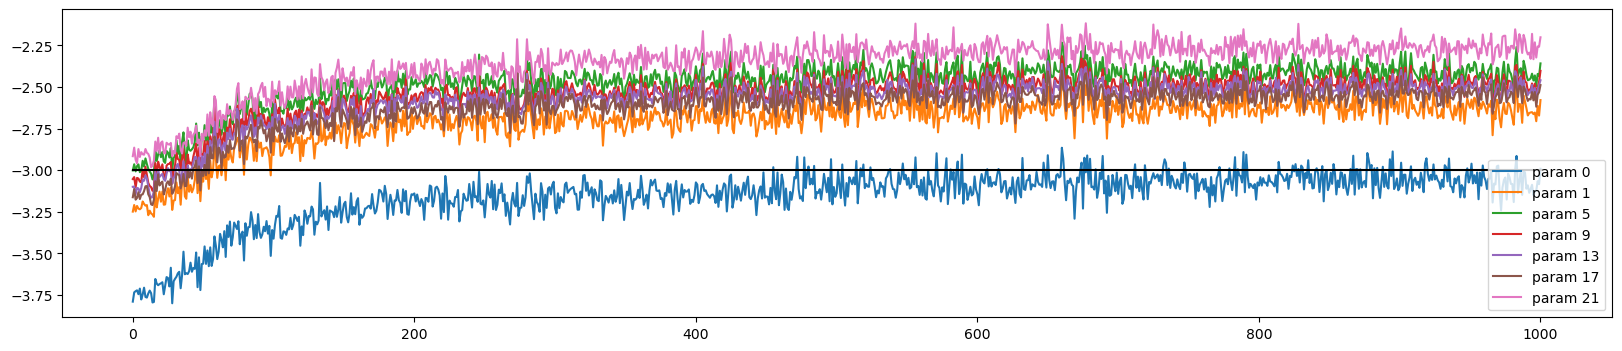

In [198]:
#gardient updates  to data  ratio visualisation

plt.figure(figsize=(20,4))
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' %i)
    
plt.plot([0, len(ud)], [-3,-3], 'k')  #these ratios should be  ~1e-3 , indicate on plot
plt.legend(legends);